<a href="https://colab.research.google.com/github/iciromaco/AliceLesson/blob/master/S6_%E3%83%99%E3%82%B8%E3%82%A8%E6%9B%B2%E7%B7%9A%E3%81%82%E3%81%A6%E3%81%AF%E3%82%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# from sympy import *
from sympy import diff,Symbol,Matrix,symbols,solve,simplify,binomial
from sympy.abc import a,b,c
# init_session()
from sympy import var
px,py =var('px:4'),var('py:4')

# Google Colaboratory の MyDrive パス
COLABRDROOT = "/content/drive/My Drive/RadiShLab"

# ホーム
LOCALHOME = "."  # フォルダを絶対指定するならここを書き変えてください


# 環境判定（Google Colaboratory かどうかの判定）
try:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(COLABRDROOT+'/rdlib')
    COLABORATORY = True
except ImportError:
    sys.path.append('./rdlib')
    COLABORATORY = False
import rdlib4 as rd

# フォルダ指定
labhome = COLABRDROOT if COLABORATORY else LOCALHOME

NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


輪郭線の画素数は、左 303  右294


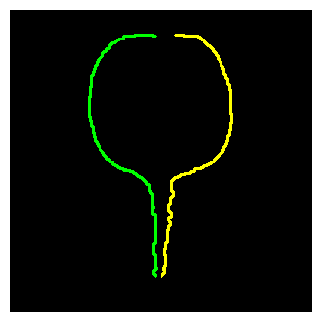

In [2]:
# 画像の左右の輪郭線を抽出　（S5参照）
img = imgs[4]
conLeft,conRight = rd.getCntPairWithImg(img)
canvas = cv2.cvtColor(np.zeros_like(img) ,cv2.COLOR_GRAY2BGR)
rd.drawContours(canvas,conLeft,color=(0,255,0),thickness=2)
rd.drawContours(canvas,conRight,color=(0,255,255),thickness=2)
plt.figure(dpi=100)
rd.plotimg(canvas)
print("輪郭線の画素数は、左 {}  右{}".format(len(conLeft),len(conRight)))

輪郭線を構成する画素の数は、この例で左右それぞれ300画素近い。

## getSamples()
> rd.getSamples(cont,N=20,mode='Equidistant')
    # 入力
    # 　cont 輪郭線構造体 開いた輪郭線を想定している
    # 　N サンプル数
    # パラメータ
    #　 mode = 'Equidistant'なら始点からの距離について等間隔 (default)
    # 　mode = 'Simple' なら単純にインデックスを等間隔

ディジタル画像は斜め方向と上下左右とで画素間の距離が異なるので、単純にインデックスを等間隔に刻むと、輪郭が斜めになっている部分と縦横に伸びている部分とでサンプリング間隔が変化してしまう。

曲線あてはめにはそれほど影響しないが、気にする場合は Equidistantを用いるとよい。

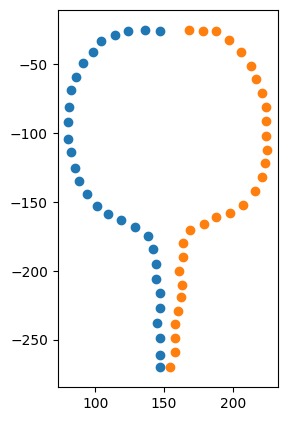

In [3]:
Left = rd.getSamples(conLeft,N=30,mode='Equidistant')
Right = rd.getSamples(conRight,N=30,mode='Simple')

plt.figure(figsize=(5,5),dpi=100)
g = plt.subplot()
g.set_aspect('equal')
plt.scatter(Left[:,0],-Left[:,1])
plt.scatter(Right[:,0],-Right[:,1]);

左が距離等間隔、右がインデックスの等間隔

# ベジエ曲線のあてはめ

## class BezierCurve:
## BezierCurve()　（コンストラクタ）
> rd.BezierCurve(samples, N=5, initialPara=[], openmode=False)
    # 入力
    #    samples   輪郭の標本
    #    N  ベジエ曲線の次数
    #    initialPara   サンプルに対するベジエ関数のパラメータの初期値
    #      デフォルトは[]であり、その場合は初期値はリニアとなる
    # パラメータ
    #    openmode=False  # 端点を自由扱い　False のときは曲線の端点をサンプルの端点位置に一致させる
    # 出力
    #    BezierCurve のインスタンス
    
> bez = BezierCurve(con,N=5)
    
> bez.fit()  あてはめの実行

> rd.BezierCurve.toggledebugmode()   デバッグ情報のオンオフ

> rd.BezierCurve.setParameters(reset=False,driftThres=0.1,errorThres=0.5,paraResolution = 0.001)  パラメータの表示とセット

> クラス変数
    # driftThres = 0.1 # 繰り返しにおけるパラメータ変動幅の平均値に対するしきい値
    # errorThres = 0.5 # 繰り返し打ち切りを決める、あてはめ誤差の平均値に対するしきい値
    # paraResolution = 0.001 # サンプル点の最寄り点探索の解像度
    

# 実行例

In [4]:
rd.BezierCurve.setParameters()

precPara:        0.1
errorThres:      0.5
paraResolution:  0.001
debugmode:       False



In [5]:
cntL = rd.getSamples(conLeft,N=20)
cntR = rd.getSamples(conRight,N=20)
bezL =  rd.BezierCurve(cntL,N=6)
bezR =  rd.BezierCurve(cntR,N=6)
rd.BezierCurve.toggledebugmode() # デバッグモードの切り替え
# BezierCurve.setParameters(driftThres=1.0,errorThres=1.0)
res,cpx,cpy,LbezresX,LbezresY,tpara = bezL.fit()
res,cpx,cpy,RbezresX,RbezresY,tpara = bezR.fit()
# BezierCurve.setParameters()



debugmode: True
.error:2.0026295048839478, drift:0.3414323111748255
.error:1.667365479628541, drift:0.2524072649802463
.error:1.716949442280253, drift:0.26466611465715895
.error:1.5055038357684285, drift:0.18913502689014156
.error:1.3451333385006172, drift:0.14496346407315466
.error:1.2246082738567021, drift:0.12036450418098077
.error:1.1344212118968233, drift:0.0988785561369861

.error:1.9696208053667434, drift:0.24785305271759883
.error:1.8299576009994758, drift:0.18593860728207887
.error:1.6996363334364328, drift:0.17224071245388126
.error:1.589648295451442, drift:0.14910390128252526
.error:1.5077434683459465, drift:0.13562254337041074
.error:1.4334243686934627, drift:0.1187630817780365
.error:1.3715906852261956, drift:0.09525981251638403



# 結果の描画

##  drawBez()
> drawBez(rdimg,bezL=None,bezR=None,bezC=None,cpl=None,cpr=None,cpc=None, 
             cntL=[],cntR=[],cntC=None, ladder=None,PosL=[],PosR=[],PosC=[],n_samples=20,saveImage=False,savepath="")
             
    # 入力
    #    rdimg  シルエット画像
    #    bezL,bezR,bezC   ベジエ曲線の定義式　3本まで描ける
    #    cpl,cpr,cpc     ベジエ曲線の制御点
    #    cntL,cntR,cntC  標本点
    # パラメータ
    #    ladder  標本点間を結ぶ線分を描画するかどうか
    #    PosL,PosR.PosC ラダーの設置点
    #    n_samples  ラダーの数
    #    saveImage 画像を保存するかどうか
    #    savepath ファイル名
    

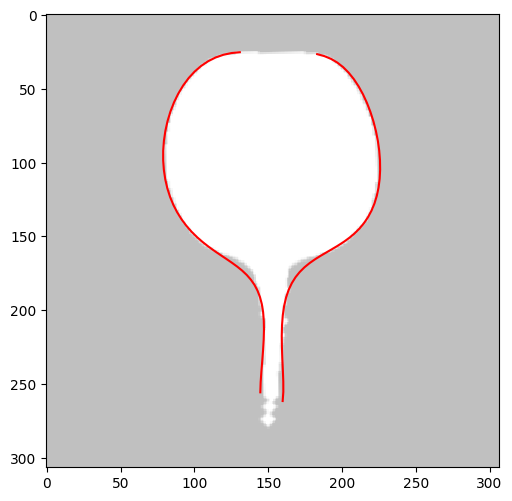

In [6]:
rd.drawBez(img,bezL=(LbezresX,LbezresY),bezR=(RbezresX,RbezresY))

In [0]:
from sympy import diff,Symbol,Matrix,symbols,solve,simplify,binomial
from sympy.abc import a,b,c
# init_session()
from sympy import var

N=6

# ベジエ曲線を定義するのに使うシンボルの宣言
P = [Symbol('P' + str(i)) for i in range(N+1)] # 制御点を表すシンボル（数値変数ではない）
px = [var('px'+str(i)) for i in range(N+1)] # 制御点のx座標を表すシンボル
py = [var('py'+str(i)) for i in range(N+1)] # 制御点のy座標を表すシンボル
t= symbols('t')
v = var('v')
for i in range(N+1):     # 制御点のシンボルと成分の対応付け
    P[i] = Matrix([px[i],py[i]]) 
    
# N次のベジエ曲線の定義式制御点 P0～PN とパラメータ　　t　の関数として定義
v = 1-t
bezN = Matrix([0,0])
for i in range(0,N+1):
    bezN = bezN + binomial(N,i)*v**(N-i)*t**i*P[i]
bezN = bezN
            

In [0]:
N=6
samples = Left
x,y = samples[:,0],samples[:,1]
M = len(x)
axlength = np.array(cv2.arcLength(samples, False)) # 点列に沿って測った総経路長
# 各サンプル点の始点からの経路長の全長に対する比を、各点のベジエパラメータの初期化とする
t = [cv2.arcLength(samples[:i+1],False)  for i in range(len(samples))]/axlength

In [0]:
def bs(N,n,t):
    return binomial(N,n)*(1-t)**n*t**(N-n)

In [0]:
exA = np.array([[sum([bs(N,i,t[k])*bs(N,n,t[k]) for k in range(M)]) for i in range(N+1)] for n in range(N+1)],'float64')

In [0]:
exBX = np.array([[sum([x[k]*bs(N,n,t[k]) for k in range(M)])] for n in range(N+1)],'float64')
exBY = np.array([[sum([y[k]*bs(N,n,t[k]) for k in range(M)])] for n in range(N+1)],'float64')

In [12]:
np.linalg.solve(exA, exBX)

array([[148.41780814],
       [120.20117904],
       [256.90855932],
       [-45.06012137],
       [ 96.73209719],
       [ 76.72900952],
       [148.19633048]])

In [13]:
np.linalg.solve(exA, exBY)

array([[268.6199365 ],
       [239.92551127],
       [ 75.4627871 ],
       [261.29728973],
       [ 39.3399569 ],
       [ 19.28657111],
       [ 25.85741247]])

In [14]:
y

array([ 26,  25,  26,  29,  33,  41,  49,  59,  69,  81,  92, 104, 114,
       125, 135, 144, 153, 159, 163, 168, 175, 184, 195, 206, 216, 227,
       238, 249, 261, 270], dtype=int32)

In [0]:
#  (23) N次ベジエフィッティング
class BezierCurve:
    
    # samples:標本点の座標の配列 （ opencv 輪郭形式、numpy 配列 ）
    # initialpara:初期の仮パラメータ値
    # N:ベジエ曲線の次数, driftThres:近似精度（繰返し計算の打ち切りしきい値）
    # order 次数、openmode: 両端点フリー、Falseの時は両端点固定
    
    driftThres = 0.1 # 繰り返しにおけるパラメータ変動幅の平均値に対するしきい値
    errorThres = 0.5 # 繰り返し打ち切りを決める、あてはめ誤差の平均値に対するしきい値
    # paraResolution = 0.001 # サンプル点の最寄り点探索の解像度
    dCount = 5 # ２分探索の打ち切り回数
    debugmode=False

    # インスタンスの初期化
    def __init__(self, samples, N=5, initialPara=[], openmode=False):
        self.N = N
        self.samples = samples # 標本点のリスト（opencv の輪郭点表現形式準拠、numpy 配列）
        self.openmode = openmode
        
        # もし、inf データが含まれるならば、補間する（計算で求められた座標データがサンプルの場合にありうる）
        samples = self.interporation(samples) 
        # パラメータの初期化
        if len(initialPara) > 0:  # 引数として与えられているならそれを使う
            if len(initialPara) != len(samples): # サンプル数と一致しない
                print("DATA NUMBER MISMATCH")
                sys.exit()
            else:
                self.tpara = initialPara
        else: # 初0～1をリニアに刻む
            axlength = np.array(cv2.arcLength(samples, False)) # 点列に沿って測った総経路長
            # 各サンプル点の始点からの経路長の全長に対する比を、各点のベジエパラメータの初期化とする
            self.tpara = [cv2.arcLength(samples[:i+1],False)  for i in range(len(samples))]/axlength
            
        # ベジエ曲線を定義するのに使うシンボルの宣言
        P = [Symbol('P' + str(i)) for i in range(N+1)] # 制御点を表すシンボル（数値変数ではない）
        px = [var('px'+str(i)) for i in range(N+1)] # 制御点のx座標を表すシンボル
        py = [var('py'+str(i)) for i in range(N+1)] # 制御点のy座標を表すシンボル
        t= symbols('t')
        v = var('v')
        for i in range(N+1):     # 制御点のシンボルと成分の対応付け
            P[i] = Matrix([px[i],py[i]]) 
            
        # N次のベジエ曲線の定義式制御点 P0～PN とパラメータ　　t　の関数として定義
        v = 1-t
        bezN = Matrix([0,0])
        for i in range(0,N+1):
            bezN = bezN + binomial(N,i)*v**(N-i)*t**i*P[i]
        self.bezN = bezN
            
    # 解なしの部分に np.inf が入っているのでその抜けを前後から推定してデータを埋める
    def interporation(self,plist):
        # plist : np.inf が混入している可能性のある座標の numpy array
        while np.sum(plist) == np.inf: # np.inf を含むなら除去を繰り返す
            for i in range(len(plist)):
                if np.sum(plist[i]) == np.inf :
                    print("欠",end="")
                    if (i !=0 and i !=len(plist)-1) and np.sum(plist[i-1]+plist[i+1]) != np.inf: # 当該は無限で、前後は無限ではない場合
                        plist = np.r_[plist[0:i],[(plist[i-1]+plist[i+1])/2],plist[i+1:]]
                    elif len(plist[i:])>=3 and np.sum(plist[i+1]+plist[i+2]) != np.inf:
                        plist = np.r_[plist[0:i],[plist[i+2]-2*(plist[i+2]-plist[i+1])],plist[i+1:]]
                    elif len(plist[0:i])>=2 and np.sum(plist[i-1]+plist[i-2]) != np.inf:
                        plist = np.r_[plist[0:i],[plist[i-2]-2*(plist[i-2]-plist[i-1])],plist[i+1:]]
        print("")
        return plist
    
    # 曲線 linefunc(t) 上で座標(x,y) に最も近い点のパラメータを2分サーチして探す関数
    def nearest(self,x,y,linefunc,pmin,pmax,dcount=5):
        t= symbols('t')
        (funcX,funcY) = linefunc # funcX,funcY は t の関数
        
        mid = (pmin+pmax)/2
        p = np.array([x,y])

        def us(p):
            x,y=p
            return np.array([float(x),float(y)])

        ps = funcX.subs(t,pmin),funcY.subs(t,pmin) # パラメータ最小点
        pm = funcX.subs(t,mid),funcY.subs(t,mid)  # 中間パラメータ点
        pe = funcX.subs(t,pmax),funcY.subs(t,pmax)  # パラメータ最大点
        ls = np.linalg.norm(us(ps) - p)
        lm = np.linalg.norm(us(pm) - p)
        le = np.linalg.norm(us(pe) - p)
        # if pmax-pmin < BezierCurve.paraResolution : # 探索範囲がこのパラメータより狭くなれば探索終了
        if dcount == 0 : # 分割回数が指定回数に到達したら探索終了
            m = min([ls,lm,le])
            if m == ls:
                return pmin
            elif m == le:
                return pmax
            else:
                return mid
        else:
            if ls < le:
                return self.nearest(x,y,linefunc,pmin,mid,dcount-1)
            else:
                return self.nearest(x,y,linefunc,mid,pmax,dcount-1)    

    #  パラメトリック曲線　linefunc 上で各サンプル点に最寄りの点のパラメータを対応づける
    def refineTparaN(self,linefunc,stt,end):
        def searchband(n):
            if n == 0:
                return 0,self.tpara[1]
            elif n == len(self.tpara)-1:
                return self.tpara[-2],1
            else:
                return self.tpara[n-1],self.tpara[n+1]

        if stt == end:
            return
        samples = self.samples
        nmid = (stt+end)//2  # 探索対象の中央のデータを抜き出す
        px,py = self.samples[nmid] # 中央のデータの座標
        #midpara = self.nearest(px,py,linefunc,pmin,pmax)
        band = searchband(nmid)
        midpara = self.nearest(px,py,linefunc,band[0],band[1],dcount= BezierCurve.dCount)
        self.tpara[nmid] = midpara
        self.refineTparaN(linefunc,stt,nmid)
        self.refineTparaN(linefunc,nmid+1,end)

    # 曲線あてはめの実行
    def fit(self):

        N = self.N

        # ベジエ曲線を定義するのに使うシンボルの宣言
        s,t= symbols('s,t')
        dx_ = [var('dx_'+str(i)) for i in range(N+1)] # 制御点におけるx微係数を表すシンボル
        dy_ = [var('dy_'+str(i)) for i in range(N+1)] # 制御点におけるy微係数を表すシンボル
        P = [Symbol('P' + str(i)) for i in range(N+1)] # 制御点を表すシンボル（数値変数ではない）
        px = [var('px'+str(i)) for i in range(N+1)] # 制御点のx座標を表すシンボル
        py = [var('py'+str(i)) for i in range(N+1)] # 制御点のy座標を表すシンボル
        
        # 最小自乗法の目的関数の一般式
        # 自乗誤差の一般式
        loss1 = (s - t)**2        
        def lossfunc(listA,listB):
            return sum([loss1.subs([(s,a),(t,b)]) for (a,b) in zip(listA,listB)])/2
        
        def bs(n,t):
            return binomial(N,n)*t**n*(1-t)**(N-n)

        trynum = 0
        while True:
            tt = self.tpara

            samples = self.samples
            openmode = self.openmode

            bezN = self.bezN
            trynum += 1

            M = len(samples)
            exA = np.array([[sum([bs(i,tt[k])*bs(n,tt[k]) for k in range(M)]) for i in range(N+1)] \
                            for n in range(N+1)],'float64')
            exBX = np.array([[sum([samples[k][0]*bs(n,tt[k]) for k in range(M)])] \
                                    for n in range(N+1)],'float64')
            exBY = np.array([[sum([samples[k][1]*bs(n,tt[k]) for k in range(M)])] \
                             for n in range(N+1)],'float64')

            rx = np.linalg.solve(exA, exBX)
            ry = np.linalg.solve(exA, exBY)

            # 解をベジエの式に代入
            if not openmode:
                bezresX = bezN[0].subs([(px[0],samples[0][0]),(px[-1],samples[-1][0])])
                bezresY = bezN[1].subs([(py[0],samples[0][1]),(py[-1],samples[-1][1])])
                for i in range(1,N):
                    bezresX = bezresX.subs(px[i],rx[i])
                    bezresY = bezresY.subs(py[i],ry[i])
            else: 
                bezresX = bezN[0]
                bezresY = bezN[1]           
                for i in range(0,N+1):
                    bezresX = bezresX.subs(px[i],rx[i])
                    bezresY = bezresY.subs(py[i],ry[i])

            if not openmode:
                cpx = [samples[0][0]]+[rx[i] for i in range(1,N)]+[samples[-1][0]]
                cpy = [samples[0][1]]+[ry[i] for i in range(1,N)]+[samples[-1][1]]    
            else: # openmode
                cpx = [rx[i] for i in range(N+1)]
                cpy = [ry[i] for i in range(N+1)]

            tpara = self.tpara
            tpara0 = tpara.copy() # 前回の t の推定値
            
            self.refineTparaN((bezresX,bezresY),0,len(samples))
            diffpara, error = 0,0
            for i in range(len(tpara)) :
                diffpara += np.sqrt((tpara[i]-tpara0[i])**2) 
                sx,sy = samples[i]
                ox,oy = float(bezresX.subs(t,tpara[i])),float(bezresY.subs(t,tpara[i]))
                error += np.sqrt((sx-ox)**2+(sy-oy)**2)
            print(".",end='')
            diffpara = diffpara/len(tpara)*100 # パラメータの変化量の平均の100倍値
            error = error/len(tpara) # あてはめ誤差の平均
            if BezierCurve.debugmode: print("error:{}, drift:{}".format(error,diffpara))
            if trynum <= 5:
                if diffpara < BezierCurve.driftThres and error < BezierCurve.errorThres:
                    print(1,diffpara,error)
                    break
            else:
                if error < BezierCurve.errorThres*1.1**(trynum-5): # 収束しない時のために、条件を徐々に緩めていく
                    print(2,diffpara,error,BezierCurve.errorThres*1.1**(trynum-5))
                    break
        print("")
        return True,np.array(cpx),np.array(cpy),bezresX,bezresY,self.tpara
        # cpx,cpy 制御点、bezresX,bezresY ベジエ曲線の定義式
        # tpara 制御点   
        
    # デバッグモードのオンオフ
    def toggledebugmode():
        BezierCurve.debugmode = not BezierCurve.debugmode
        print("debugmode:",BezierCurve.debugmode)
        
    # パラメータのセットと表示　引数なしで呼ぶ出せば初期化
    def setParameters(reset=False,driftThres=0.1,errorThres=0.5,dCount=5):
        
        BezierCurve.driftThres = driftThres # 繰り返しにおけるパラメータ変動幅の平均値に対するしきい値
        BezierCurve.errorThres = errorThres # 繰り返し打ち切りを決める、あてはめ誤差の平均値に対するしきい値
        BezierCurve.dCount = dCount # サンプル点の最寄り点探索の解像度
        
        print("driftThres:       ",driftThres)
        print("errorThres:     ",errorThres)
        print("dCount: ",dCount)
        print("debugmode:      ",BezierCurve.debugmode)
        print("")
        

In [65]:
%%time
cntL = rd.getSamples(conLeft,N=20)
cntR = rd.getSamples(conRight,N=20)
bezL =  BezierCurve(cntL,N=8,openmode=False)
bezR =  BezierCurve(cntR,N=8,openmode=False)
BezierCurve.toggledebugmode() # デバッグモードの切り替え
BezierCurve.setParameters(driftThres=0.01,errorThres=0.1)
res,cpx,cpy,LbezresX,LbezresY,tpara = bezL.fit()
res,cpx,cpy,RbezresX,RbezresY,tpara = bezR.fit()
BezierCurve.setParameters()



debugmode: True
driftThres:        0.01
errorThres:      0.1
dCount:  5
debugmode:       True

.error:1.027298102380506, drift:0.16611649919574656
.error:0.8646496885210937, drift:0.1253907963430151
.error:0.8718250681701173, drift:0.09151481742812169
.error:0.7730927274050976, drift:0.08081094097754885
.error:0.8219847266350705, drift:0.06696520757423087
.error:0.7541056193335529, drift:0.05527724599894576
.error:0.8035782078014997, drift:0.06245321346429175
.error:0.7241974127649318, drift:0.07917629068749064
.error:0.7672041254741614, drift:0.06448101536103062
.error:0.7104369063107203, drift:0.06193967081313222
.error:0.7535182258387139, drift:0.05454551661912034
.error:0.7018692998208658, drift:0.06234565318698329
.error:0.751237929510073, drift:0.06224565827696649
.error:0.6932306262002866, drift:0.05927438512306285
.error:0.7455927298002685, drift:0.05783199576808021
.error:0.6888805621737395, drift:0.05653278490389535
.error:0.7388289769485188, drift:0.05225333291994187
.erro

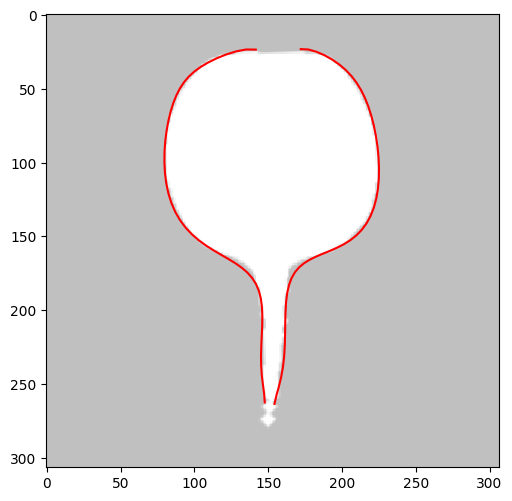

In [66]:
rd.drawBez(img,stt=0.02,end=0.98,bezL=(LbezresX,LbezresY),bezR=(RbezresX,RbezresY))

In [71]:
%%time
cntL = rd.getSamples(conLeft,N=20)
cntR = rd.getSamples(conRight,N=20)
bezL =  BezierCurve(cntL,N=8,openmode=False)
bezR =  BezierCurve(cntR,N=8,openmode=False)
BezierCurve.toggledebugmode() # デバッグモードの切り替え
BezierCurve.setParameters(driftThres=0.01,errorThres=0.1,dCount=10)
res,cpx,cpy,LbezresX,LbezresY,tpara = bezL.fit()
res,cpx,cpy,RbezresX,RbezresY,tpara = bezR.fit()
BezierCurve.setParameters()



debugmode: True
driftThres:        0.01
errorThres:      0.1
dCount:  10
debugmode:       True

.error:1.009120968150095, drift:0.15610715511815737
.error:0.8472859366259522, drift:0.10986813986978844
.error:0.8694441210678704, drift:0.09649010378131463
.error:0.7599806566211088, drift:0.08401666283344193
.error:0.7973760625934696, drift:0.07805511319593086
.error:0.7216070277293759, drift:0.07057164387744841
.error:0.7567286675982436, drift:0.06531788193870819
.error:0.6991422009396653, drift:0.060382237008416995
.error:0.7312454499187463, drift:0.05680763169622301
.error:0.6840299108103893, drift:0.05277033494796295
.error:0.7152371621943178, drift:0.049561411315806776
.error:0.6733756868597204, drift:0.046149109672967356
.error:0.7060579772361397, drift:0.0445972143778324
.error:0.6657970768877097, drift:0.041905719050756365
.error:0.7001354608650451, drift:0.04022354468735126
.error:0.6612484777510084, drift:0.038177622072852156
.error:0.7051462365185468, drift:0.0412826091471250

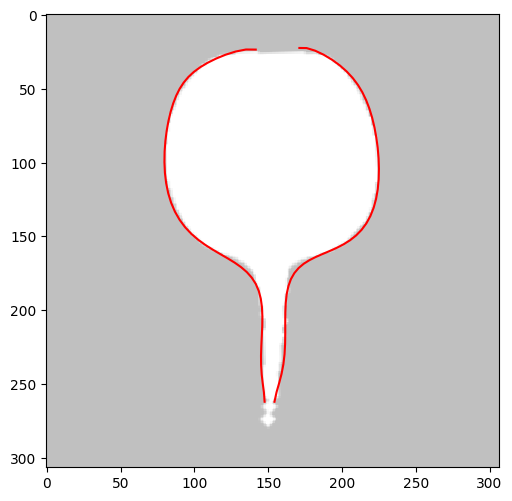

In [72]:
rd.drawBez(img,stt=0.02,end=0.98,bezL=(LbezresX,LbezresY),bezR=(RbezresX,RbezresY))